In [ ]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_dir = "/home/saher/Documents/data_preprocessed_matlab"
file_names = [f"s{i:02d}.mat" for i in range(1, 33)]  

X_data = []
y_participant = []
y_clip = []

for participant_id, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(data_dir, file_name)
    mat = scipy.io.loadmat(file_path)
    
    eeg_data = mat['data']  
    
    for clip_id in range(40):
        clip_data = eeg_data[clip_id, :32, 384:]  
        
        for second in range(60):
            start_idx = second * 128
            end_idx = (second + 1) * 128
            second_data = clip_data[:, start_idx:end_idx]
            
            X_data.append(second_data)
            y_participant.append(participant_id - 1)  
            y_clip.append(clip_id)  

X_data = np.array(X_data)
y_participant = np.array(y_participant)
y_clip = np.array(y_clip)

participant_encoder = LabelEncoder()
clip_encoder = LabelEncoder()

y_participant_encoded = participant_encoder.fit_transform(y_participant)
y_clip_encoded = clip_encoder.fit_transform(y_clip)

y_participant_onehot = tf.keras.utils.to_categorical(y_participant_encoded, num_classes=len(participant_encoder.classes_))
y_clip_onehot = tf.keras.utils.to_categorical(y_clip_encoded, num_classes=len(clip_encoder.classes_))

scaler = StandardScaler()
X_data = X_data.reshape(-1, 32 * 128)  
X_data = scaler.fit_transform(X_data)
X_data = X_data.reshape(-1, 32, 128) 

def create_model():
    input_layer = tf.keras.layers.Input(shape=(32, 128))
    
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    participant_output = tf.keras.layers.Dense(len(participant_encoder.classes_), activation='softmax', name='participant_output')(x)
    clip_output = tf.keras.layers.Dense(len(clip_encoder.classes_), activation='softmax', name='clip_output')(x)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=[participant_output, clip_output])
    
    model.compile(optimizer='adam', 
                  loss={'participant_output': 'categorical_crossentropy', 'clip_output': 'categorical_crossentropy'},
                  metrics={'participant_output': 'accuracy', 'clip_output': 'accuracy'})
    return model

train_test_splits = np.arange(0.1, 1.0, 0.1)
participant_accuracies = []
clip_accuracies = []

for split in train_test_splits:
    print(f"Running for train-test split: {split:.1f}")
    
    X_train, X_test, y_train_participant, y_test_participant, y_train_clip, y_test_clip = train_test_split(
        X_data, y_participant_onehot, y_clip_onehot, test_size=split, random_state=42
    )
    
    model = create_model()
    history = model.fit(X_train, 
                        {'participant_output': y_train_participant, 'clip_output': y_train_clip},
                        validation_data=(X_test, {'participant_output': y_test_participant, 'clip_output': y_test_clip}),
                        epochs=30, batch_size=32, verbose=1)  
    
    scores = model.evaluate(X_test, {'participant_output': y_test_participant, 'clip_output': y_test_clip}, verbose=1)

Running for train-test split: 0.1
Epoch 1/30
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - clip_output_accuracy: 0.0254 - loss: 5.4193 - participant_output_accuracy: 0.6515 - val_clip_output_accuracy: 0.0314 - val_loss: 3.8106 - val_participant_output_accuracy: 0.9905
Epoch 2/30
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - clip_output_accuracy: 0.0313 - loss: 3.8426 - participant_output_accuracy: 0.9796 - val_clip_output_accuracy: 0.0380 - val_loss: 3.7275 - val_participant_output_accuracy: 0.9958
Epoch 3/30
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - clip_output_accuracy: 0.0382 - loss: 3.7495 - participant_output_accuracy: 0.9897 - val_clip_output_accuracy: 0.0384 - val_loss: 3.7131 - val_participant_output_accuracy: 0.9960
Epoch 4/30
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - clip_output_accuracy: 0.0415 - loss: 3.7130 - participant_output_accuracy: 0.9914 - val_clip_output_accuracy: 0.0413 - val_loss: 3.6782 - val_participant_output_accuracy: 0.9969
Epoch 5/30
2160/2160 ━━━━━

In [7]:
participant_accuracies = [0.9987, 0.9977, 0.9980, 0.9980, 0.9972, 0.9952, 0.9921, 0.9875, 0.9774]

clip_accuracies = [0.4727, 0.4491, 0.3490, 0.2483, 0.1590, 0.1114, 0.0521, 0.0342, 0.0285]


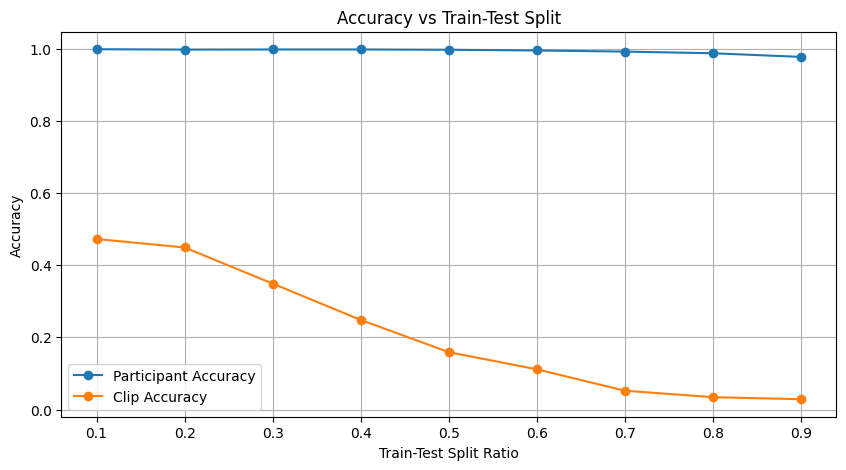

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_test_splits, participant_accuracies, marker='o', label='Participant Accuracy')
plt.plot(train_test_splits, clip_accuracies, marker='o', label='Clip Accuracy')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Train-Test Split')
plt.legend()
plt.grid(True)
plt.show()